In [1]:
%matplotlib inline
import torchio as tio
import torch
import numpy as np
from scipy.ndimage import binary_erosion, binary_dilation
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

def compute_diff(volume, order_of_derivation=1):
    """Compute the continuity of a volume.

    Args:
        volume (np.array): 4D volume (batch, height, width, channels)
        order_of_derivation (int, optional): Order of derivation. Defaults to 1.

    Returns:
        np.array: Continuity of the volume in specified order of derivation ranging in [0, 1]
    """
    diff = volume.astype(np.int16)
    for _ in range(order_of_derivation):
        diff = diff[:, :, :, 1:] - diff[:, :, :, :-1]
    
    diff = np.abs(diff)
    return diff.mean()

def morph_open(volume, structuring_element, iterations=1):
    for _ in range(iterations):
        volume = binary_erosion(volume, structuring_element)
        volume = binary_dilation(volume, structuring_element)
    return volume

def morph_close(volume, structuring_element, iterations=1):
    for _ in range(iterations):
        volume = binary_dilation(volume, structuring_element)
        volume = binary_erosion(volume, structuring_element)
    return volume

def create_spherical_structure(radius):
    # Create a grid of the appropriate size
    L = np.arange(-radius, radius+1)
    X, Y, Z = np.meshgrid(L, L, L)
    
    # Calculate the distance from the center
    distance = np.sqrt(X**2 + Y**2 + Z**2)
    
    # Create the spherical structuring element
    structure = distance <= radius
    return structure

def create_elipsoidal_structure(radius_x, radius_y, radius_z):
    # Create a grid of the appropriate size
    r_max = max(radius_x, radius_y, radius_z)
    L = np.arange(-r_max, r_max+1)
    X, Y, Z = np.meshgrid(L, L, L)
    
    # Calculate the distance from the center
    distance = (X/radius_x)**2 + (Y/radius_y)**2 + (Z/radius_z)**2
    
    # Create the spherical structuring element
    structure = distance <= 1
    return structure

def compute_dice(pred, gt):
    intersection = np.logical_and(pred, gt).sum()
    return 2 * intersection / (pred.sum() + gt.sum())

In [2]:
fold_0_dir = Path('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_results/Dataset302_Calcium_OCTv2/nnUNetTrainer__nnUNetPlans__2d/fold_0/validation')
fold_1_dir = Path('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_results/Dataset302_Calcium_OCTv2/nnUNetTrainer__nnUNetPlans__2d/fold_1/validation')
fold_2_dir = Path('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_results/Dataset302_Calcium_OCTv2/nnUNetTrainer__nnUNetPlans__2d/fold_2/validation')
fold_dirs = [fold_0_dir, fold_1_dir, fold_2_dir]

label_dir = Path('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_raw/Dataset302_Calcium_OCTv2/labelsTr')
d2_volume_paths = []
d2_label_paths = []
for fold_dir in fold_dirs:
    for nifty in fold_dir.glob('*.nii.gz'):
        d2_volume_paths.append(nifty)
        assert (label_dir / nifty.name).exists(), "Label not found, please check the label directory."
        d2_label_paths.append(label_dir / nifty.name)

fold_0_3d_32x160x128 = Path('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_results/Dataset302_Calcium_OCTv2/nnUNetTrainer__nnUNetPlans__3d_32x160x128_b10/fold_0_pretrained_LaW/validation')
fold_1_3d_32x160x128 = Path('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_results/Dataset302_Calcium_OCTv2/nnUNetTrainer__nnUNetPlans__3d_32x160x128_b10/fold_1_pretrained_LaW/validation')
fold_2_3d_32x160x128 = Path('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_results/Dataset302_Calcium_OCTv2/nnUNetTrainer__nnUNetPlans__3d_32x160x128_b10/fold_2_pretrained_LaW/validation')

d3_volume_paths = []
d3_label_paths = []
for fold_dir in [fold_0_3d_32x160x128, fold_1_3d_32x160x128, fold_2_3d_32x160x128]:
    for nifty in fold_dir.glob('*.nii.gz'):
        d3_volume_paths.append(nifty)
        assert (label_dir / nifty.name).exists(), "Label not found, please check the label directory."
        d3_label_paths.append(label_dir / nifty.name)

fold_0_3d_32x512x512 = Path('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_results/Dataset302_Calcium_OCTv2/nnUNetTrainer__nnUNetPlans__3d_32x512x512_b2/fold_0_pretrained_LaW/validation')
fold_1_3d_32x512x512 = Path('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_results/Dataset302_Calcium_OCTv2/nnUNetTrainer__nnUNetPlans__3d_32x512x512_b2/fold_1_pretrained_LaW/validation')
fold_2_3d_32x512x512 = Path('/storage_bizon/naravich/nnUNet_Datasets/nnUNet_results/Dataset302_Calcium_OCTv2/nnUNetTrainer__nnUNetPlans__3d_32x512x512_b2/fold_2_pretrained_LaW/validation')

d3_512_volume_paths = []
d3_512_label_paths = []
for fold_dir in [fold_0_3d_32x512x512, fold_1_3d_32x512x512, fold_2_3d_32x512x512]:
    for nifty in fold_dir.glob('*.nii.gz'):
        d3_512_volume_paths.append(nifty)
        assert (label_dir / nifty.name).exists(), "Label not found, please check the label directory."
        d3_512_label_paths.append(label_dir / nifty.name)

In [3]:
def evaluate_a_post_process_function(volumn_path, label_path, post_process_function):
    volume = tio.ScalarImage(volumn_path).data.numpy()
    label = tio.LabelMap(label_path).data.numpy()
    post_procesed_volumn = post_process_function(volume[0])[np.newaxis, ...]
    dice = compute_dice(post_procesed_volumn, label)
    derivative = compute_diff(post_procesed_volumn)
    derivative_2 = compute_diff(post_procesed_volumn, 2)
    derivative_3 = compute_diff(post_procesed_volumn, 3)
    return {
        'dice': dice,
        'derivative': [derivative, derivative_2, derivative_3]
    }

def create_post_process_function(structure):
    def post_process_function(volume):

        assert volume.min() == 0 and volume.max() == 1, "Volume must be binary, 0 or 1 but got {} and {}".format(volume.min(), volume.max())
        assert np.unique(structure).size == 2, "Structure must be binary."

        volume = volume == 1
        volume = morph_open(volume, structure, iterations=1)
        volume = morph_close(volume, structure, iterations=1)
        return volume
    return post_process_function

def get_post_process_functions():
    sphere_r1 = create_spherical_structure(1)
    sphere_r2 = create_spherical_structure(2)
    sphere_r3 = create_spherical_structure(3)

    ellipse_r1x1x2 = create_elipsoidal_structure(1, 1, 2)
    ellipse_r1x1x3 = create_elipsoidal_structure(1, 1, 3)

    ellipse_r2x2x3 = create_elipsoidal_structure(2, 2, 3)

    operations = [
        ('orignal', lambda x: x),
        ('sphere_r1', create_post_process_function(sphere_r1)),
        ('sphere_r2', create_post_process_function(sphere_r2)),
        ('sphere_r3', create_post_process_function(sphere_r3)),
        ('ellipse_r1x1x2', create_post_process_function(ellipse_r1x1x2)),
        ('ellipse_r1x1x3', create_post_process_function(ellipse_r1x1x3)),
        ('ellipse_r2x2x3', create_post_process_function(ellipse_r2x2x3))
    ]
    return operations

In [6]:
dices = defaultdict(list)
derivative_1s = defaultdict(list)
derivative_2s = defaultdict(list)
derivative_3s = defaultdict(list)

post_process_functions = get_post_process_functions()

model_predictions = [('2D', d2_volume_paths, d2_label_paths), ('3D_32x160x128', d3_volume_paths, d3_label_paths), ('3D_32x512x512', d3_512_volume_paths, d3_512_label_paths)]
for model_name, volume_paths, label_paths in model_predictions:
    for volume_path, label_path in zip(volume_paths, label_paths):
        for func_name, func in post_process_functions:
            name = f'{model_name}_{func_name}'
            result = evaluate_a_post_process_function(volume_path, label_path, func)
            dice = result['dice']
            derivative_1, derivative_2, derivative_3 = result['derivative']

            dices[name].append(dice)
            derivative_1s[name].append(derivative_1)
            derivative_2s[name].append(derivative_2)
            derivative_3s[name].append(derivative_3)

In [ ]:
# import copy

# dices_with_3d = copy.deepcopy(dices)
# derivative_1s_with_3d = copy.deepcopy(derivative_1s)
# derivative_2s_with_3d = copy.deepcopy(derivative_2s)
# derivative_3s_with_3d = copy.deepcopy(derivative_3s)

# noop = lambda x: x
# name = '2d_original'
# for volume_path, label_path in zip(d2_volume_paths, d2_label_paths):
#     result = evaluate_a_post_process_function(volume_path, label_path, noop)
#     dice = result['dice']
#     derivative_1_mean_and_std, derivative_2_mean_and_std, derivative_3_mean_and_std = result['derivative']

#     dices_with_3d[name].append(dice)
#     derivative_1s_with_3d[name].append(derivative_1_mean_and_std)
#     derivative_2s_with_3d[name].append(derivative_2_mean_and_std)
#     derivative_3s_with_3d[name].append(derivative_3_mean_and_std)

# name = '3d_32x160x128'
# for volume_path, label_path in zip(d3_volume_paths, d3_label_paths):
#     result = evaluate_a_post_process_function(volume_path, label_path, noop)
#     dice = result['dice']
#     derivative_1_mean_and_std, derivative_2_mean_and_std, derivative_3_mean_and_std = result['derivative']

#     dices_with_3d[name].append(dice)
#     derivative_1s_with_3d[name].append(derivative_1_mean_and_std)
#     derivative_2s_with_3d[name].append(derivative_2_mean_and_std)
#     derivative_3s_with_3d[name].append(derivative_3_mean_and_std)

# name = '3d_32x512x512'
# for volume_path, label_path in zip(d3_512_volume_paths, d3_512_label_paths):
#     result = evaluate_a_post_process_function(volume_path, label_path, noop)
#     dice = result['dice']
#     derivative_1_mean_and_std, derivative_2_mean_and_std, derivative_3_mean_and_std = result['derivative']

#     dices_with_3d[name].append(dice)
#     derivative_1s_with_3d[name].append(derivative_1_mean_and_std)
#     derivative_2s_with_3d[name].append(derivative_2_mean_and_std)
#     derivative_3s_with_3d[name].append(derivative_3_mean_and_std)


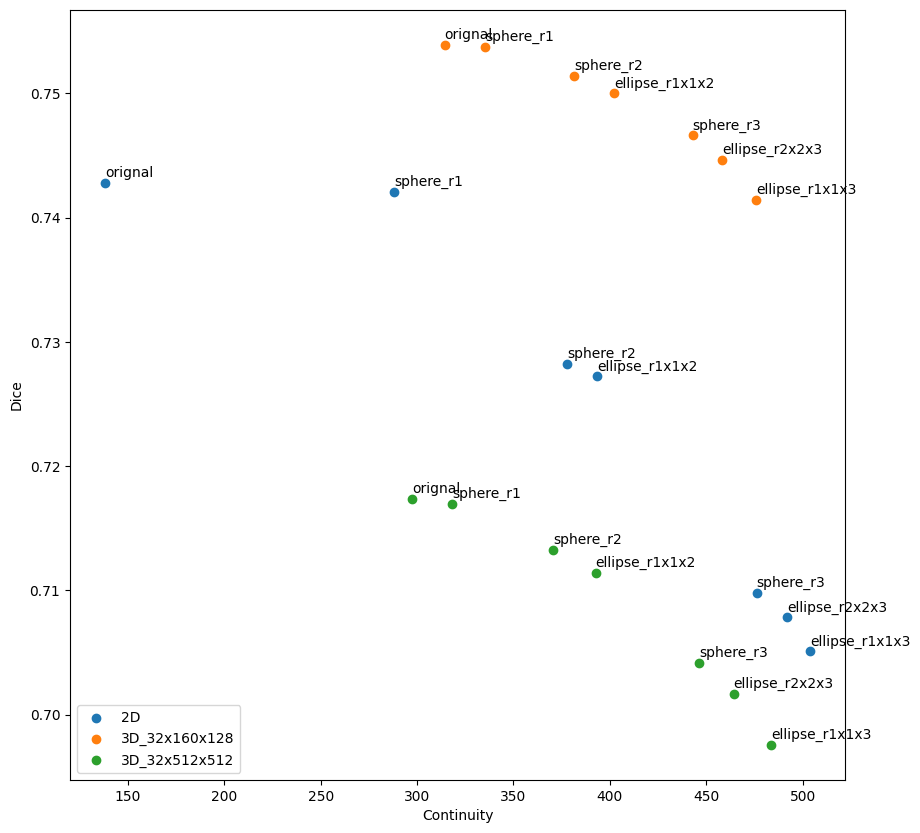

In [24]:
def average_std_of_same_sample_size(stds):
    return np.sqrt(np.sum(stds ** 2) / len(stds))

def extract_mean_and_std(derivative):
    means = []
    stds = []
    for mean, std in derivative:
        means.append(mean)
        stds.append(std)
    return np.array(means), np.array(stds)
    
plt.figure(figsize=(10, 10))

model_names = [model_name for model_name, _, _ in model_predictions]
for model_name in model_names:
    operation_names = list(dices.keys())
    operation_names = [name for name in operation_names if model_name in name]
    avg_dice = [np.mean(dices[name]) for name in operation_names]

    avg_continuity_1st = np.array([np.mean(derivative_1s[name]) for name in operation_names])
    avg_continuity_1st = 1 / avg_continuity_1st

    # avg_continuity_2nd = np.array([np.mean(derivative_2s[name]) for name in operation_names])
    # avg_continuity_2nd = 1 / avg_continuity_2nd

    # avg_continuity_3rd = np.array([np.mean(derivative_3s[name]) for name in operation_names])
    # avg_continuity_3rd = 1 / avg_continuity_3rd

    x = avg_continuity_1st
    y = avg_dice


    plt.scatter(x, y)

    for i, txt in enumerate(operation_names):
        plt.annotate(txt[len(model_name) + 1:], (x[i] + 0.0005, y[i] + 0.0005)) # put the label on the point

plt.legend(model_names, loc='lower left')
plt.xlabel('Continuity')
plt.ylabel('Dice')


plt.show()